Example adapted from https://github.com/pytorch/examples/blob/master/mnist/main.py.

In this notebook we train a small NN on MNIST, and display the second moment of the gradients (a.k.a. the empirical Fisher) at several points in training. We denote it by F. We also display F projected in the KFE (defined in George et al, NIPS 2018).

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from ekfac import EKFAC

import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 15, 5, 1)
        self.fc1 = nn.Linear(4*4*15, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*15)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Size of weight matrix: torch.Size([50, 240])


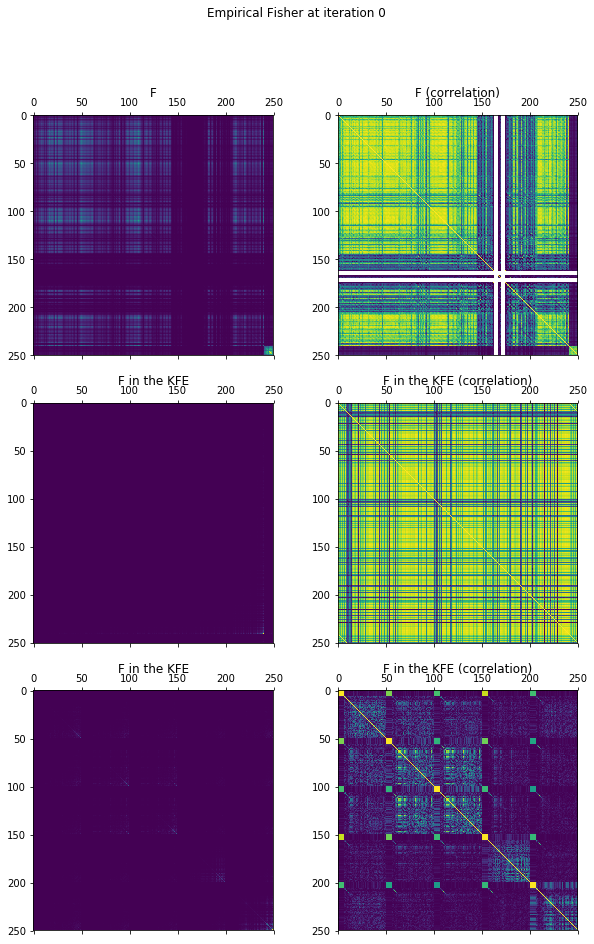

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308313
Size of weight matrix: torch.Size([50, 240])


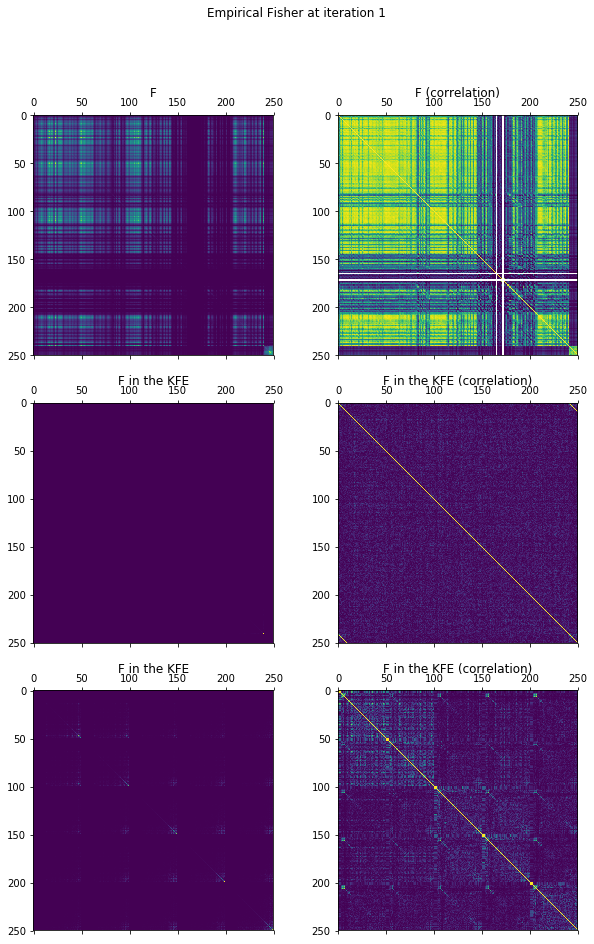

Size of weight matrix: torch.Size([50, 240])


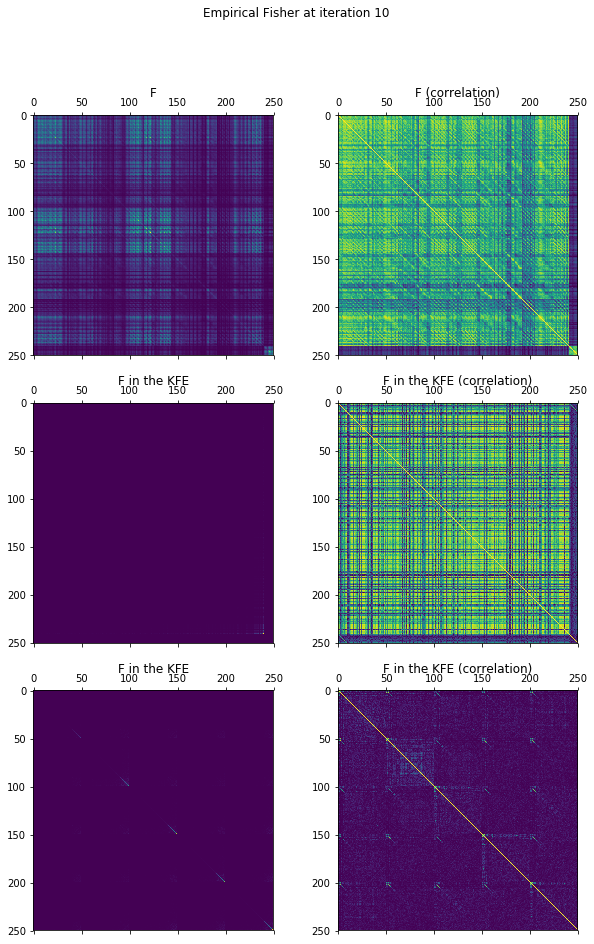

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.909295
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.244540
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.154722
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.105354
Size of weight matrix: torch.Size([50, 240])


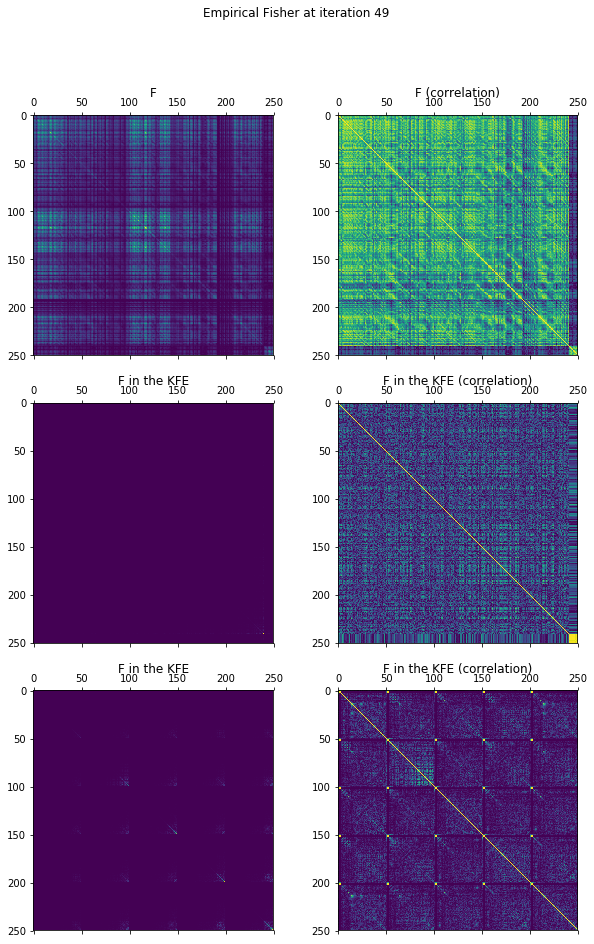

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.100528

Test set: Average loss: 0.0691, Accuracy: 9786/10000 (98%)



In [2]:
def train(args, model, device, train_loader, optimizer, preconditioner, epoch, analyze):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        preconditioner.step()
        analyze(batch_idx, model, preconditioner)
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def display_mat(axis, A, correlation=False, cut_at=None):
    if cut_at is not None:
        A = A[:cut_at, :cut_at]
    if correlation:
        A_diag = torch.diag(A)
        A = A / (A_diag**.5).view(-1, 1) / (A_diag**.5).view(1, -1)
    axis.matshow(torch.abs(A).detach().cpu())
    
def analyze(iteration_number, model, preconditioner):
    if iteration_number in [0, 1, 10, 49]:
        # layer 2
        layer = preconditioner.param_groups[2]
        print('Size of weight matrix:', layer['params'][0].size())
        
        # get kfe basis
        kfe_x = preconditioner.state[layer['params'][0]]['kfe_x']
        kfe_gy = preconditioner.state[layer['params'][0]]['kfe_gy']

        # get activation and gradient for layer
        x = preconditioner.state[layer['mod']]['x']
        ones = torch.ones_like(x[:, :1]) 
        x = torch.cat([x, ones], dim=1) # add bias
        gy = preconditioner.state[layer['mod']]['gy']
        bs = x.size(0) # batch size
        
        F = torch.zeros((x.size(1)*gy.size(1), x.size(1)*gy.size(1)), device=x.device)
        F_kfe = torch.zeros((kfe_x.size(1)*kfe_gy.size(1), kfe_x.size(1)*kfe_gy.size(1)), device=x.device)
        F_kfe_permuted = torch.zeros((kfe_x.size(1)*kfe_gy.size(1), kfe_x.size(1)*kfe_gy.size(1)), device=x.device)
        # loop through examples:
        for i in range(bs):
            g_theta = torch.ger(gy[i, :], x[i, :])
            F += torch.ger(g_theta.view(-1), g_theta.view(-1))
            
            g_theta_kfe = torch.mm(torch.mm(kfe_gy.t(), g_theta), kfe_x)
            F_kfe += torch.ger(g_theta_kfe.view(-1), g_theta_kfe.view(-1))
            F_kfe_permuted += torch.ger(g_theta_kfe.t().contiguous().view(-1), g_theta_kfe.t().contiguous().view(-1))
        F /= bs
        F_kfe /= bs
        F_kfe_permuted /= bs
        
        f, axes = plt.subplots(3, 2, figsize=(10, 15))
        f.suptitle('Empirical Fisher at iteration %d' % (iteration_number, ))
        display_mat(axes[0][0], F, cut_at=250)
        display_mat(axes[0][1], F, cut_at=250, correlation=True)
        display_mat(axes[1][0], F_kfe, cut_at=250)
        display_mat(axes[1][1], F_kfe, cut_at=250, correlation=True)
        display_mat(axes[2][0], F_kfe_permuted, cut_at=250)
        display_mat(axes[2][1], F_kfe_permuted, cut_at=250, correlation=True)
        axes[0][0].set_title('F')
        axes[0][1].set_title('F (correlation)')
        axes[1][0].set_title('F in the KFE')
        axes[1][1].set_title('F in the KFE (correlation)')
        axes[2][0].set_title('F in the KFE')
        axes[2][1].set_title('F in the KFE (correlation)')
        plt.show()
                
        
def main():
    args = {
        'batch_size': 1000,
        'test_batch_size': 1000,
        'epochs': 1,
        'lr': 0.01,
        'eps': 0.01,
        'log_interval': 10,
        'seed': 1111
    }
    use_cuda = torch.cuda.is_available()

    torch.manual_seed(args['seed'])

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args['batch_size'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args['test_batch_size'], shuffle=True, **kwargs)

    model = Net().to(device)
    preconditioner = EKFAC(model, eps=args['eps'], alpha=1.)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'])

    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, preconditioner, epoch, analyze)
        test(args, model, device, test_loader)
        
if __name__ == '__main__':
    main()